# Histogram Matching

Using histogram matching, we can take the color distribution of one image and match it to another.

It manipulates the pixels of an input image so that its histogram matches the histogram of the reference image. If the images have multiple channels, the matching is done independently for each channel, as long as the number of channels is equal in the input image and the reference.

Histogram matching can be used as a lightweight normalisation for image processing, such as feature matching, especially in circumstances where the images have been taken from different sources or in different conditions (i.e. lighting).

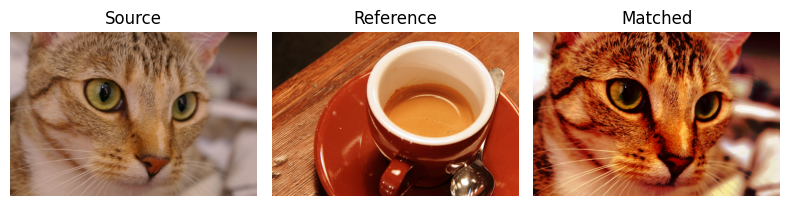

In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

reference = data.coffee()
image = data.chelsea()

matched = match_histograms(image, reference, channel_axis=-1)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

To illustrate the effect of the histogram matching, we plot for each RGB channel, the histogram and the cumulative histogram. Clearly, the matched image has the same cumulative histogram as the reference image for each channel.

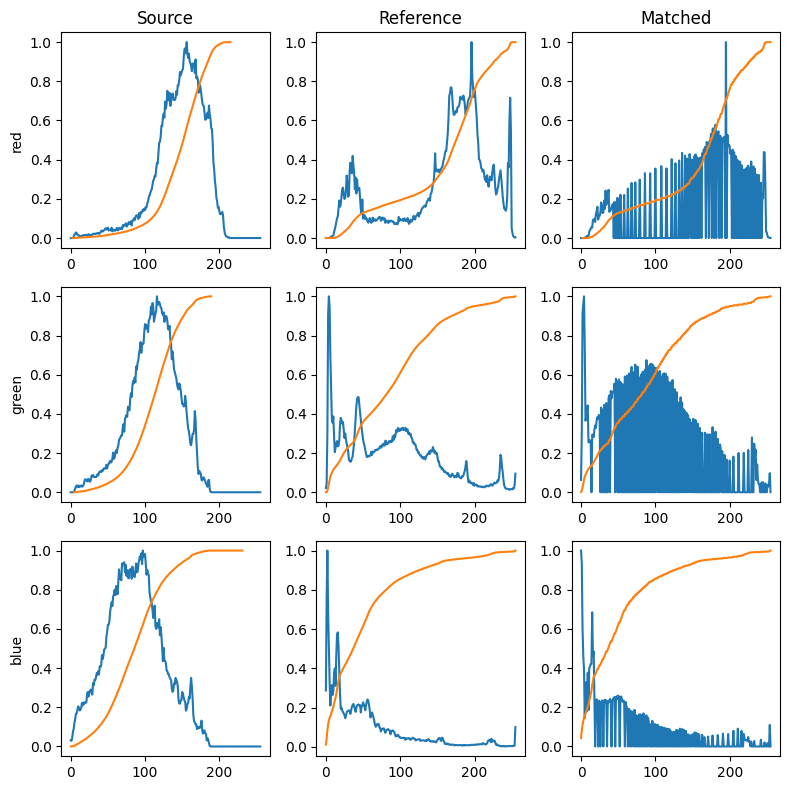

In [2]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))


for i, img in enumerate((image, reference, matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max())
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf)
        axes[c, 0].set_ylabel(c_color)

axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')

plt.tight_layout()
plt.show()

If you want to store this 'transformation' you have two options:

The first and straightforward method is to keep passing your reference image when applying the matching.

The alternative would be to store the relevant quantile for each channel calculated by skimage's _match_cumulative_cdf function, which is used by match_histograms under the hood and apply the interpolation in the same manner as the function.

In [ ]:
def _match_cumulative_cdf(source, template):
    """
    Return modified source array so that the cumulative density function of
    its values matches the cumulative density function of the template.
    """
    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)
    tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / template.size

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)
    return interp_a_values[src_unique_indices].reshape(source.shape)